In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats
import aesara.tensor as at

In [3]:
az.style.use('arviz-darkgrid')

# Gaussian Mixture model

In [5]:
n = 20

mu1 = np.ones(n) * (1. / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
logdsigma = np.linalg.slogdet(sigma)[1]

w1 = 0.1
w2 = (1 - w1)

In [6]:
def two_gaussians(x):
    log_like1 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    log_like2 = - 0.5 * n * at.log(2 * np.pi) \
                - 0.5 * logdsigma \
                - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    return pm.math.logsumexp([at.log(w1) + log_like1, at.log(w2) + log_like2])

In [7]:
with pm.Model() as model:
    X = pm.Uniform('X',
                   shape=n,
                   lower=-2. * np.ones_like(mu1),
                   upper=2. * np.ones_like(mu1),
                   testval=-1. * np.ones_like(mu1))
    llk = pm.Potential('llk', two_gaussians(X))

/Users/ciguaran/personal/pymc/pymc/distributions/continuous.py:167: FutureWarning: The `testval` argument is deprecated; use `initval`.
  return super().__new__(cls, *args, **kwargs)


In [8]:
with model:
    idata_nuts = pm.sample(5000, cores=1)

Only 10 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [X]


Sampling 2 chains for 1_000 tune and 10 draw iterations (2_000 + 20 draws total) took 3 seconds.
/var/folders/hy/9qct0wrx5pl34rzz153ys6sw0000gp/T/ipykernel_2684/1936045292.py:2: UserWarning: The number of samples is too small to check convergence reliably.
  idata_nuts = pm.sample(10, cores=1)


In [12]:
with model:
    idata_smc = pm.sample_smc(5000, cores=1, progressbar=True) 

Initializing SMC sampler...
Sampling 2 chains in 1 job


In [37]:
with model:
    idata_smc_hmc = pm.sample_smc(100, kernel=pm.smc.HMC, 
                                  n_steps=15,
                                  path_length=10,
                                  max_steps=16,
                                  vars=None,
                                  cores=1,
                                  chains=4)

Initializing SMC sampler...
Sampling 4 chains in 1 job


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:177: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  return sample_prior_predictive(
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


In [38]:
def results(idata):
    ax = az.plot_trace(idata, compact=True, kind="rank_vlines")
    ax[0, 0].axvline(-0.5, 0, .9, color="k")
    ax[0, 0].axvline(0.5, 0, 0.1, color="k")
    ax[0, 0].set_xlim(-1, 1)
    np.mean(idata.posterior["X"] > 0).item()

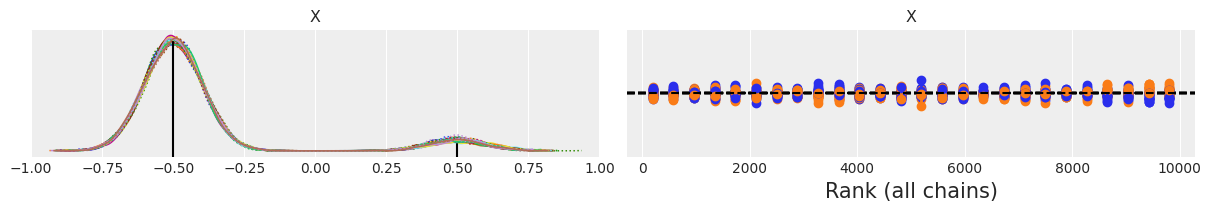

In [26]:
results(idata_smc)

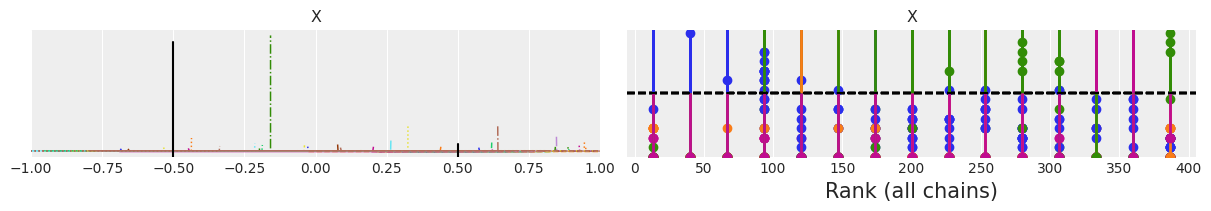

In [39]:
results(idata_smc_hmc)

# Example with less chains

In [28]:
with model:
    idata_smc_hmc_2 = pm.sample_smc(100, kernel=pm.smc.HMC, 
                                  n_steps=15,
                                  path_length=10,
                                  max_steps=16,
                                  vars=None,
                                  cores=1,
                                  chains=2)

Initializing SMC sampler...
Sampling 2 chains in 1 job


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:177: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  return sample_prior_predictive(
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


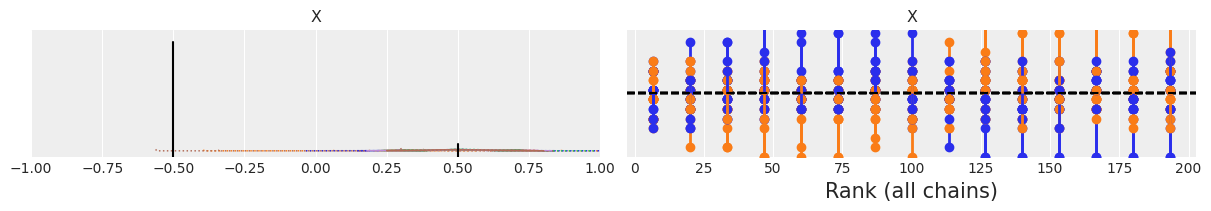

In [32]:
results(idata_smc_hmc_2)

# Increasing path length

In [34]:
with model:
    idata_smc_hmc_3 = pm.sample_smc(100, kernel=pm.smc.HMC, 
                                  n_steps=15,
                                  path_length=50,
                                  max_steps=16,
                                  vars=None,
                                  cores=1,
                                  chains=4)

Initializing SMC sampler...
Sampling 4 chains in 1 job


/Users/ciguaran/personal/pymc/pymc/smc/smc.py:177: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  return sample_prior_predictive(
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/ciguaran/personal/SMC_diagnostics/venv2/lib/python3.8/site-packages/arviz/stats/density_utils.py:481: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data a

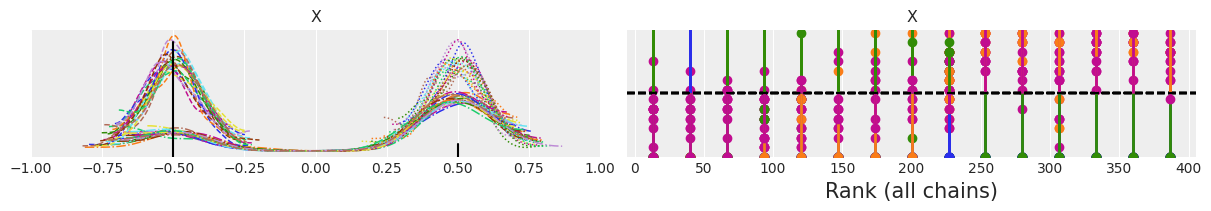

In [35]:
results(idata_smc_hmc_3)

# Compute error score

In [33]:
def compute_error_score(idata):
    # Wang bimodality index True Value
    BI = abs(mu1 - mu2) * (w1*(1-w1))**0.5
    posterior = idata.posterior
    error_score_list = []

    for chain in posterior["chain"]:
        for dimension in posterior["X_dim_0"]:
            v = np.ravel(posterior.isel(chain=chain, X_dim_0=dimension)["X"])
            above_zero = v > 0
            below_zero = v < 0
            w1_ = np.mean(below_zero)
            if np.any(above_zero) and np.any(below_zero):
                BI_ = abs(v[below_zero].mean() - v[above_zero].mean()) * (w1_*(1-w1_))**0.5
            else:
                BI_ = 0
            error_score = (np.mean(((v-mu1[0]) * w1 + (v-mu2[0]) * w2))**2)**0.5 + abs(BI - BI_)
            error_score_list.append(error_score)

    np.mean(error_score_list), np.std(error_score_list)

# Hierarchical Model

For this model we may use NUTS as a "gold-standard"

In [41]:
data = pd.read_csv('radon.csv')

county_names = data.county.unique()
county_idx = data['county_code'].values.astype(np.int32)
n_counties = len(data.county.unique())

In [50]:
with pm.Model() as hierarchical_model_non_centered:
    mu_a = pm.Normal('mu_a', mu=0., sd=5)
    sigma_a = pm.HalfNormal('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=5)
    sigma_b = pm.HalfNormal('sigma_b', 5)
     
    a_offset = pm.Normal('a_offset', mu=0, sd=2, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)
    b_offset = pm.Normal('b_offset', mu=0, sd=2, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)
 
    eps = pm.HalfNormal('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)

In [51]:
with hierarchical_model_non_centered:
    idata_nuts_hierarchical = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, a_offset, b_offset, eps]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 38 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 55 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [52]:
with hierarchical_model_non_centered:
    idata_smc_hierarchical = pm.sample_smc(5000, cores=1)

Initializing SMC sampler...
Sampling 2 chains in 1 job


The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [57]:
with hierarchical_model_non_centered:
    idata_smc_hmc_hierarchical = pm.sample_smc(100, kernel=pm.smc.HMC,
                                       n_steps=4,
                                       path_length=10,
                                       max_steps=16,
                                       vars=None,
                                       cores=1,
                                       progressbar=True)

Initializing SMC sampler...
Sampling 2 chains in 1 job


The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective samples is smaller than 10% for some parameters.


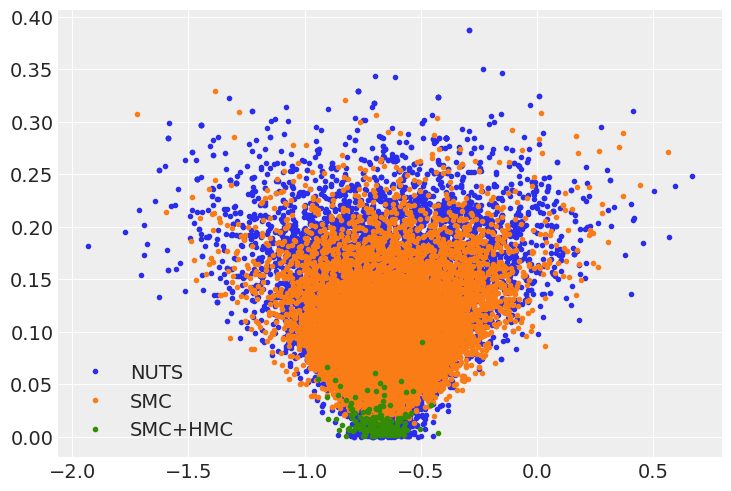

In [58]:
nuts_posterior = idata_nuts_hierarchical.posterior.stack(samples=("chain", "draw"))
smc_posterior = idata_smc_hierarchical.posterior.stack(samples=("chain", "draw"))
smc_hmc_posterior = idata_smc_hmc_hierarchical.posterior.stack(samples=("chain", "draw"))
plt.plot(nuts_posterior["b"].isel(b_dim_0=75), nuts_posterior["sigma_b"], '.C0', label="NUTS")
plt.plot(smc_posterior["b"].isel(b_dim_0=75), smc_posterior["sigma_b"], '.C1', label="SMC")
plt.plot(smc_hmc_posterior["b"].isel(b_dim_0=75), smc_hmc_posterior["sigma_b"], '.C2', label="SMC+HMC")

plt.legend();